# Linear Regression with PyMC - 2025-05-06
This notebook demonstrates how to perform simple linear regression using a fully Bayesian approach with **PyMC**.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
np.random.seed(1234)

## Simulate data

In [2]:
x = np.arange(1, 21)
a = 0.2
b = 0.3
sigma = 0.5
epsilon = np.random.normal(0, sigma, size=20)
y = a + b * x + epsilon
data = pd.DataFrame({'x': x, 'y': y})
data.head()

,x,y
0,1,0.735718
1,2,0.204512
2,3,1.816353
3,4,1.243674
4,5,1.339706


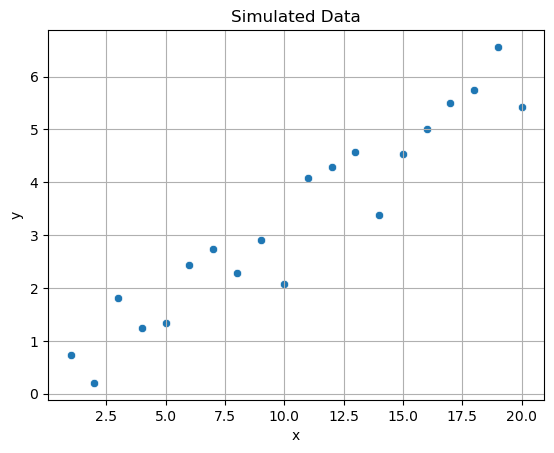

In [3]:
sns.scatterplot(data=data, x='x', y='y')
plt.title('Simulated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

## Bayesian Linear Regression using PyMC

In [13]:
with pm.Model() as linear_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = alpha + beta * data['x']
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=data['y'])

    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [14]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.24,0.29,-0.29,0.80,0.01,0.01,1534.18,1782.74,1.0
beta,0.30,0.02,0.25,0.34,0.00,0.00,1524.44,1649.34,1.0
sigma,0.60,0.11,0.42,0.80,0.00,0.00,1668.35,1628.11,1.0


In [18]:
with linear_model:
    ppc = pm.sample_posterior_predictive(trace.posterior, var_names=["y_obs"])

# run the following two lines if you want to see the posterior predictive plot
# az.plot_ppc(ppc, observed=True, num_pp_samples=100)
#plt.show()


Sampling: [y_obs]


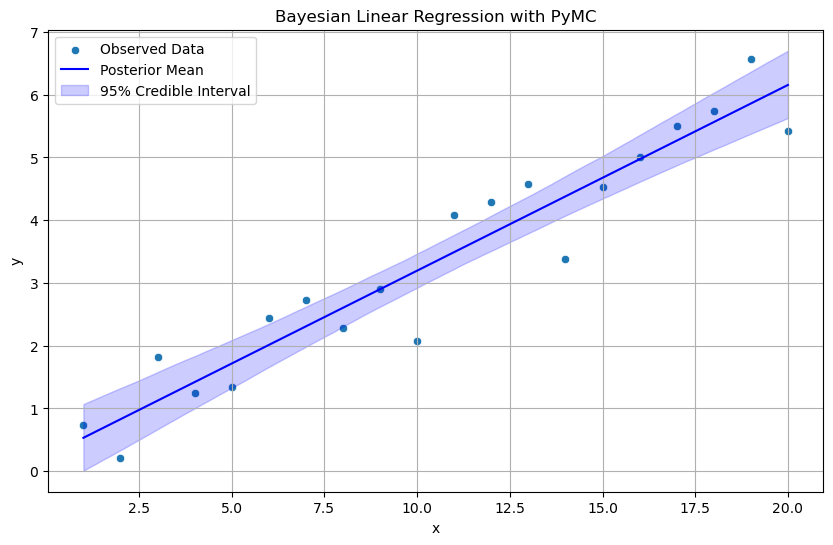

In [19]:
import xarray as xr

x_vals = np.linspace(data['x'].min(), data['x'].max(), 100)

# Get stacked posterior samples (1D arrays)
alpha_samples = trace.posterior['alpha'].stack(draws=("chain", "draw")).values
beta_samples = trace.posterior['beta'].stack(draws=("chain", "draw")).values

# Broadcast across x_vals (outer product-style)
y_preds = np.outer(beta_samples, x_vals) + alpha_samples[:, None]  # shape: (n_samples, 100)

# Compute summary statistics
y_mean = y_preds.mean(axis=0)
y_lower = np.percentile(y_preds, 2.5, axis=0)
y_upper = np.percentile(y_preds, 97.5, axis=0)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='x', y='y', label='Observed Data')
plt.plot(x_vals, y_mean, color='blue', label='Posterior Mean')
plt.fill_between(x_vals, y_lower, y_upper, color='blue', alpha=0.2, label='95% Credible Interval')
plt.title('Bayesian Linear Regression with PyMC')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()
